<a href="https://colab.research.google.com/github/Rogerio-mack/work/blob/main/Projeto1_Rogerio_de_Oliveira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Quantum Classifier (VQC)**

<small>
Rogério de Oliveira | rogerio.oliveira@mackenzie.br

<br>
<br>
<br>

# 1. Introdução e Objetivos

## Variational Quantum Classifier (VQC)

Um **Variational Quantum Classifier (VQC)** é um modelo de aprendizado de máquina quântico inspirado na ideia de circuitos variacionais parametrizados.
Ele é chamado "variacional" porque os parâmetros do circuito são variáveis ajustáveis (ângulos de rotações, por exemplo), que são otimizados para minimizar uma função de custo. Ele é um **classificador híbrido quântico-clássico**, onde os dados são projetados em um espaço quântico via codificação, transformados por um ansatz parametrizado (circuito variacional) e as expectativas de observáveis são usadas como logits para classificação.

Seu **funcionamento é semelhante ao de uma rede neural clássica**. Os parâmetros do circuito quântico fazem o papel dos pesos de uma rede neural. O circuito quântico parametrizado substitui a camada oculta e a medida quântica fornece as saídas (features transformadas em espaço quântico). O treinamento consiste em ajusta os parâmetros para minimizar a perda e a otimização é feita por uma **método clássico de otimização** (e por isso, **um método híbrido quântico-clássico**).

## Classificador `iris`  

Neste notebook implementamos um classificador VQC para o dataset `iris` e comparamos os resultados com modelos clássicos aprendizado de máquina (`SVM`, `RandomForest` e `LogistRegression`).

# 2. Implementação

A implementação, sendo necessário vários ajustes até a convergência do modelo, segue a seguinte estrutura:

1. VQC para duas classes de `iris`
> Empregando 2 features (**2 qubits**) e **acuracidade** como função de custo. Otimizador **GradientDescentOptimizer**.

2. VQC para as 3 classes de `iris`
> Empregando 4 features (**4 qubits**) e **cross-entropy** como função de custo.
Otimizador **AdamOptimizer**.

3. VQC para as 3 classes de `iris` com PCA
> Aplicando um **PCA** para reduzir o tempo do treinamento quântico. Empregando 4 features, mas dimensão reduzida para 2 features com PCA (**2 qubits**) e **cross-entropy** como função de custo. Otimizador **AdamOptimizer**.

4. Modelos clássicos

In [ ]:
# Instalar pennylane
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 85.5 MB/s eta 0:00:00


## 2.1. VQC para duas classes de `iris`

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(train_losses, train_accs, y_test, y_pred):
  fig, ax = plt.subplots(1,3,figsize=(12,3.5))

  ax[0].plot(train_losses, label="Train Loss")
  ax[0].set_xlabel("Épocas")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Evolução da Loss")
  ax[0].legend()

  ax[1].plot(train_accs, label="Train Accuracy", color="green")
  ax[1].set_xlabel("Épocas")
  ax[1].set_ylabel("Acurácia")
  ax[1].set_title("Evolução da Acurácia")
  ax[1].legend()

  cm = confusion_matrix(y_test, y_pred) # Ensure y_test is float if needed
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(ax=ax[2],cmap=plt.cm.Blues,colorbar=False)
  ax[2].set_title("Confusion Matrix")

  # Display classification report
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  plt.show()



Epoch 5: Train loss = 0.2223 Accurancy = 0.6000
Epoch 10: Train loss = 0.1858 Accurancy = 0.7000
Epoch 15: Train loss = 0.1583 Accurancy = 0.8000
Epoch 20: Train loss = 0.1385 Accurancy = 0.8714
Epoch 25: Train loss = 0.1244 Accurancy = 0.8857
Epoch 30: Train loss = 0.1143 Accurancy = 0.8857

Test Accuracy: 0.9666666666666667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        17
         1.0       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



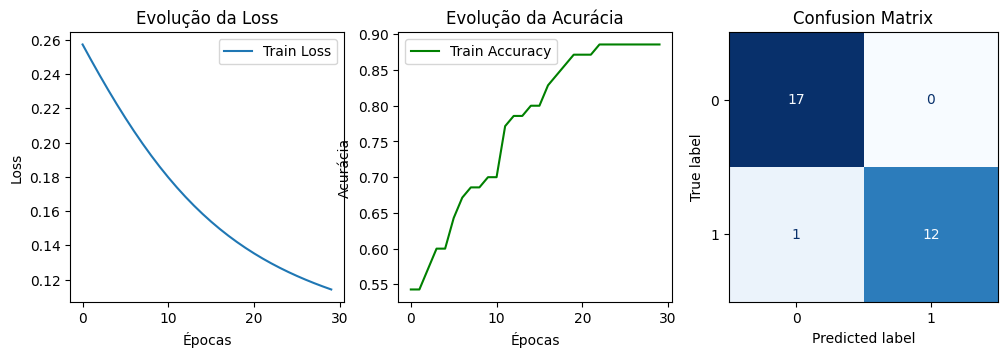

CPU times: user 1min 34s, sys: 82.9 ms, total: 1min 34s
Wall time: 1min 34s


In [ ]:
%%time
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Iris (2 classes)
iris = datasets.load_iris()
X = iris.data[iris.target != 2]        # apenas classes 0 e 1
y = iris.target[iris.target != 2]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X[:, :2]  # apenas 2 features para 2 qubits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---- Circuito Variacional ----
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def circuit(params, x):
    qml.AngleEmbedding(x, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def variational_classifier(params, x):
    return circuit(params, x)

def cost(params, X, y):
    preds = [variational_classifier(params, x) for x in X]
    preds = np.array(preds)
    # converte valores esperados de [-1,1] -> [0,1]
    preds = (1 - preds)/2
    return np.mean((preds - y)**2)

# ---- Inicialização ----
np.random.seed(42)
init_params = np.random.randn(n_layers, n_qubits, 3, requires_grad=True)

# ---- Otimização ----
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params = init_params

train_losses, train_accs = [], []

epochs = 30
for epoch in range(epochs):
    params = opt.step(lambda v: cost(v, X_train, y_train), params)
    loss = cost(params, X_train, y_train)

    # calcular acurácia no treino
    y_pred_train = [variational_classifier(params, x) for x in X_train]
    # Convert y_pred_train to a NumPy array
    y_pred_train_np = np.array(y_pred_train)
    # Convert predicted probabilities to binary predictions (0 or 1)
    y_pred_train_binary = (1 - y_pred_train_np) / 2 > 0.5
    acc = accuracy_score(y_train, y_pred_train_binary)

    train_losses.append(loss)
    train_accs.append(acc)

    if (epoch+1) % 5 == 0:
      print(f"Epoch {epoch+1}: Train loss = {loss:.4f} Accurancy = {acc:.4f}")

# ---- Avaliação ----
preds = [variational_classifier(params, x) for x in X_test]
preds = np.array((1 - np.array(preds))/2 > 0.5, dtype=int)
acc = np.mean(preds == y_test)
print("\nTest Accuracy:", acc)

plot_history(train_losses, train_accs, np.array(y_test, dtype=float), np.array(preds, dtype=float))

## 2.2. VQC para as 3 classes de `iris`

Epoch 5: Loss = 1.0388, Accuracy = 0.619
Epoch 10: Loss = 0.9946, Accuracy = 0.686
Epoch 15: Loss = 0.9512, Accuracy = 0.771
Epoch 20: Loss = 0.9158, Accuracy = 0.829
Epoch 25: Loss = 0.8888, Accuracy = 0.819
Epoch 30: Loss = 0.8653, Accuracy = 0.848

Test Accuracy: 0.8666666666666667

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       0.77      0.77      0.77        13
         2.0       0.77      0.77      0.77        13

    accuracy                           0.87        45
   macro avg       0.85      0.85      0.85        45
weighted avg       0.87      0.87      0.87        45



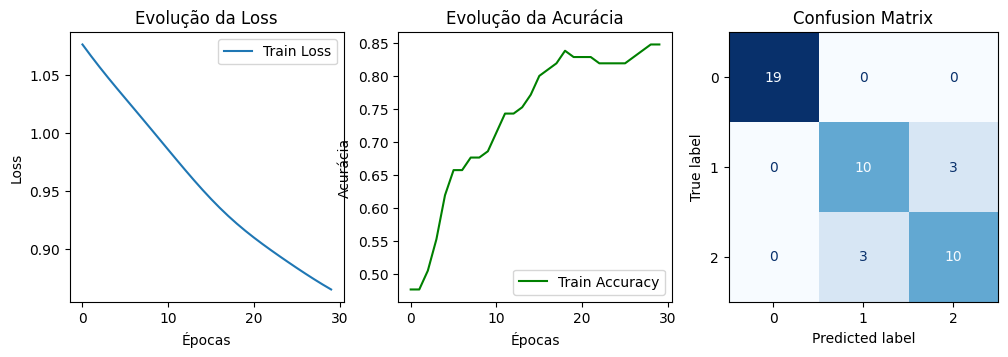

CPU times: user 4min 43s, sys: 238 ms, total: 4min 43s
Wall time: 4min 45s


In [ ]:
%%time
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ---- Dataset Iris (3 classes) ----
iris = datasets.load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Padronização
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encoding
enc = OneHotEncoder(sparse_output=False)
y_onehot = enc.fit_transform(y)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.3, random_state=42
)

# ---- Circuito Variacional ----
n_qubits = 4   # 4 features → 4 qubits
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def circuit(params, x):
    qml.AngleEmbedding(x, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

def variational_classifier(params, x):
    logits = circuit(params, x)
    logits = (1 - np.array(logits)) / 2
    exp_vals = np.exp(logits - np.max(logits))
    return exp_vals / np.sum(exp_vals)

# ---- Função de custo (Cross-Entropy) ----
def cost(params, X, Y):
    loss = 0
    for i, x in enumerate(X):
        probs = variational_classifier(params, x)
        loss -= np.dot(Y[i], np.log(probs + 1e-8))
    return loss / len(X)

# ---- Inicialização ----
np.random.seed(42)
init_params = np.random.randn(n_layers, n_qubits, 3, requires_grad=True)

# ---- Otimização ----
opt = qml.AdamOptimizer(stepsize=0.02)
params = init_params

epochs = 30
train_losses, train_accs = [], []

for epoch in range(epochs):
    params = opt.step(lambda v: cost(v, X_train, y_train), params)
    loss = cost(params, X_train, y_train)

    # calcular acurácia no treino
    y_pred_train = [np.argmax(variational_classifier(params, x)) for x in X_train]
    y_true_train = np.argmax(y_train, axis=1)
    acc = accuracy_score(y_true_train, y_pred_train)

    train_losses.append(loss)
    train_accs.append(acc)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.3f}")

# ---- Avaliação no teste ----
y_pred = [np.argmax(variational_classifier(params, x)) for x in X_test]
y_true = np.argmax(y_test, axis=1)
acc_test = accuracy_score(y_true, y_pred)
print("\nTest Accuracy:", acc_test)

plot_history(train_losses, train_accs, np.array(y_true, dtype=float), np.array(y_pred, dtype=float))



## 2.3. VQC para as 3 classes de `iris` com PCA

Epoch 5: Loss = 0.9823, Accuracy = 0.619
Epoch 10: Loss = 0.9689, Accuracy = 0.648
Epoch 15: Loss = 0.9522, Accuracy = 0.629
Epoch 20: Loss = 0.9463, Accuracy = 0.610
Epoch 25: Loss = 0.9464, Accuracy = 0.610
Epoch 30: Loss = 0.9401, Accuracy = 0.610

Test Accuracy: 0.7111111111111111

Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        19
         1.0       0.76      1.00      0.87        13
         2.0       0.00      0.00      0.00        13

    accuracy                           0.71        45
   macro avg       0.48      0.67      0.56        45
weighted avg       0.51      0.71      0.59        45



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


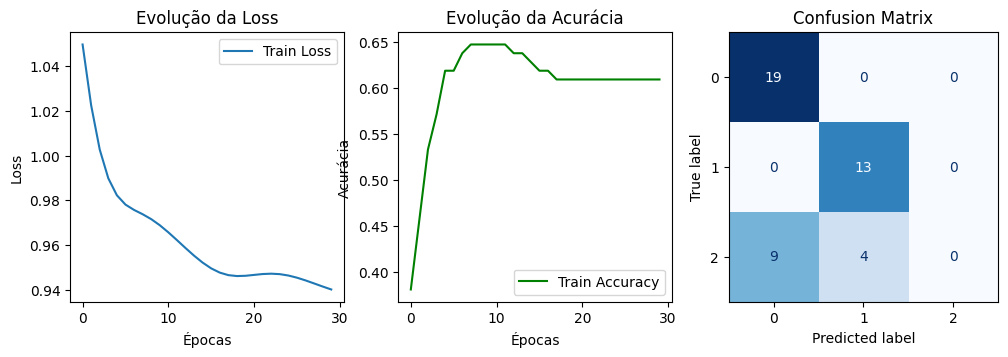

CPU times: user 2min 38s, sys: 137 ms, total: 2min 38s
Wall time: 2min 40s


In [ ]:
%%time
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ---- Dataset Iris (3 classes) ----
iris = datasets.load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA para reduzir para 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# One-hot encoding
enc = OneHotEncoder(sparse_output=False)
y_onehot = enc.fit_transform(y)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_onehot, test_size=0.3, random_state=42
)

# ---- Circuito Variacional ----
n_qubits = 2   # 2 features → 2 qubits
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def circuit(params, x):
    qml.AngleEmbedding(x, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(2)] + [qml.expval(qml.PauliZ(0))]

def variational_classifier(params, x):
    logits = circuit(params, x)
    logits = (1 - np.array(logits)) / 2
    exp_vals = np.exp(logits - np.max(logits))
    return exp_vals / np.sum(exp_vals)

# ---- Função de custo (Cross-Entropy) ----
def cost(params, X, Y):
    loss = 0
    for i, x in enumerate(X):
        probs = variational_classifier(params, x)
        loss -= np.dot(Y[i], np.log(probs + 1e-8))
    return loss / len(X)

# ---- Inicialização ----
np.random.seed(42)
init_params = np.random.randn(n_layers, n_qubits, 3, requires_grad=True)

# ---- Otimização ----
opt = qml.AdamOptimizer(stepsize=0.05)
params = init_params

epochs = 30
train_losses, train_accs = [], []

for epoch in range(epochs):
    params = opt.step(lambda v: cost(v, X_train, y_train), params)
    loss = cost(params, X_train, y_train)

    y_pred_train = [np.argmax(variational_classifier(params, x)) for x in X_train]
    y_true_train = np.argmax(y_train, axis=1)
    acc = accuracy_score(y_true_train, y_pred_train)

    train_losses.append(loss)
    train_accs.append(acc)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.3f}")

# ---- Avaliação no teste ----
y_pred = [np.argmax(variational_classifier(params, x)) for x in X_test]
y_true = np.argmax(y_test, axis=1)
acc_test = accuracy_score(y_true, y_pred)
print("\nTest Accuracy:", acc_test)

plot_history(train_losses, train_accs, np.array(y_true, dtype=float), np.array(y_pred, dtype=float))


## 2.4. Modelos Clássicos

### SVM, com kernel RBF

In [ ]:
def plot_results(y_test, y_pred):
  fig, ax = plt.subplots(1,1,figsize=(4,3.5))

  cm = confusion_matrix(y_test, y_pred) # Ensure y_test is float if needed
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(ax=ax,cmap=plt.cm.Blues,colorbar=False)
  ax.set_title("Confusion Matrix")

  # Display classification report
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  plt.show()


Test Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


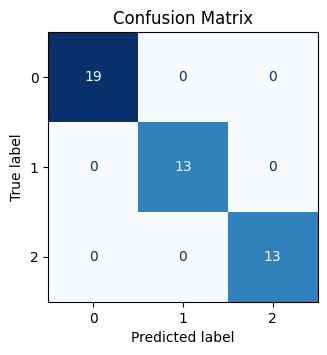

CPU times: user 98.3 ms, sys: 992 µs, total: 99.3 ms
Wall time: 99.2 ms


In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---- Dataset Iris (3 classes) ----
iris = datasets.load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Padronização
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Support Vector Machine
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train, y_train)

# ---- Avaliação no teste ----
y_pred = model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", acc_test)

plot_results(y_test, y_pred)

### Random Forest

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Test Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



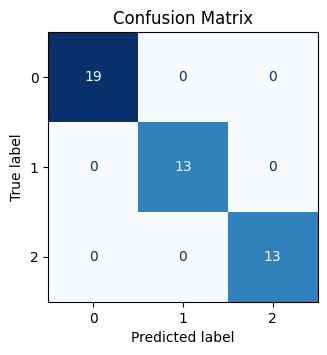

CPU times: user 364 ms, sys: 0 ns, total: 364 ms
Wall time: 385 ms


In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---- Dataset Iris (3 classes) ----
iris = datasets.load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Padronização
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---- Avaliação no teste ----
y_pred = model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", acc_test)

plot_results(y_test, y_pred)

# 3. Resultados

Segue um sumário dos resultados. Os resultados são com base na última execução e podem variar em novas execuções. As visualizações do aprendizado e o detalhe das métricas de cada modelo foram exibidos anteriormente.

| Modelo | acuracidade | tempo exec |
|--------|-------------|------------|
| VQC 2 classes | 0.97 | 1min 34s |
| **VQC 3 classes** | **0.87** | **4min 45s** |
| VQC 3 classes PCA | **0.71** | 2min 40s |
| **SVM** | 1.00 | **99.2 ms** |
| Random Forest | 1.00 | 385 ms |

# 4. Discussão

1. **Performance**: Modelos clássicos superaram o VQC em todas as métricas
2. **Eficiência**: VQC foi $2000-3000 \times$ mais lento que SVM, e com resultado de ~14% inferior (acuracidade, modelo sem PCA).
3. **Treinamento**: Chegou a bons resultados convergindo para uma acuracidade > 0.7 em menos de 30 épocas. Mas trata-se de um problema muito simples e podemos esperar problemas de convergência e tempo muito superior no caso de problemas mais complexos. A partir de 30 épocas a maior parte dos modelos entrou em um platô do treinamento.
4. **PCA**: O PCA pode ser uma boa abordagem com redução do custo computacional. O tempo cai para metade sem uma perda proporcional de eficiência (redução de ~20% da acuracidade com relação ao modelo sem PCA).

# 5. Conclusão

Este estudo implementou e comparou um **Variational Quantum Classifier (VQC)** com modelos clássicos de machine learning para classificação do dataset `iris`. O VQC mesmo, para um conjunto de dados simples como o `iris`, apresentou resultados do treinamento bastante abaixo dos modelos clássicos e com um custo computacional (tempo de processamento) bastante maior.

A vantagem da computação quântica, entranto, pode se apresentar em outros cenários como a possibilidade de n qubits, pode representar $2^n$ estados simultaneamente, representar correlações não-clássicas entre features impossíveis classicamente (**entrelaçamento quântico**) e processamento simultâneo de múltiplas possibilidades. O que torna os algoritmos de aprendizado de máquina quânticos, potencialmente interessantes. O VQC, particularmente, tem a restrição (se é que podemos empregar essa palavra aqui) de ser um algoritmo híbrido, dependente de um **otimizador clássico**.  

Em um trabalho futuro, a partir desse estudo, podemos implementar a classificação de dados mais complexos. Inicialmente tentei fazer com o MNIST, mas não tive bons resultados e empreguei o `iris` por ter um conjunto de dados menor, menos features e classes. Mas, concluído este, creio que a implementação possa ser facilmente adaptada para novos conjuntos de dados. Uma técnica de **validação cruzada** poderia resultar é métricas mais corretas que o uso de um único conjunto de teste. Mas isso demandaria um tempo muito grande de processamento e não foi empregado aqui. Também deve ser interessante verificar como evolui o treinamento com o uso de **ansatz** mais profundos, $10-20$, aqui nos limitamos a empregar apenas $2$ e $3$ camadas.